# Models
In this notebook we will generate several different models using the already engineered features. We will then evaluate the models using cross validation and select the best model to use for our predictions.

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [22]:
GEO = 'texas_florida'
df = pd.read_csv(f'../../data/features/features_{GEO}_pca.csv')
df.index = df["review_id"]
df.drop(columns=["review_id"], inplace=True)

print(df.shape)
df.head()

(1546, 96)


,pca_comments_0,pca_comments_1,pca_comments_2,pca_description_0,pca_description_1,pca_description_2,3gram09_would_not_recommend,3gram09_no_toilet_paper,3gram09_not_recommend_staying,3gram09_write_negative_review,...,amenityall_silverware,amenityall_bathtub,amenityall_lockbox,amenityall_crib,amenityall_elevator,amenityall_gym,amenityall_oven,amenityall_waterfront,amenityall_toilet,label
review_id,,,,,,,,,,,,,,,,,,,,,
83097,-0.054448,-0.088134,-0.023753,0.222688,-0.220573,0.155973,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,good
133337,-0.145413,0.213364,-0.030841,0.222688,-0.220573,0.155973,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,good
150928,0.001356,-0.114448,0.075398,0.222688,-0.220573,0.155973,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,good
2706775,-0.248564,-0.142601,0.024358,0.222688,-0.220573,0.155973,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,good
8602878,0.039454,-0.030109,0.011850,0.222688,-0.220573,0.155973,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,good


In [23]:
df.label.value_counts()

good     1236
mbad      124
mgood     106
bad        80
Name: label, dtype: int64

Drop NA labels... THANKS Charlie :/

In [24]:
df = df.dropna()

The data is extremely imbalanced. We can use the `imbalanced-learn` Python library, which has several implementations of resampling methods to deal with this problem. We will use the `SMOTE` method, which oversamples the minority class.

In [25]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(df.drop(columns=["label"]), df["label"])

print("Balanced labels:")
y.value_counts()

Balanced labels:


good     1236
mgood    1236
mbad     1236
bad      1236
Name: label, dtype: int64

## Testing out different feature combinations
We want to try the different combinations of features to see which ones work best.

In [48]:
import itertools

feature_sets = [
    "pca_comments_",
    "pca_description_",
    "3gram09_",
    "3gram10_",
    "amenity005_",
    "amenityall_"
]

# get all combinations of feature sets of all lengths
feature_sets_combinations = []
for i in range(1, len(feature_sets) + 1):
    feature_sets_combinations += [list(x) for x in itertools.combinations(feature_sets, i)]

print(f"Number of feature sets combinations: {len(feature_sets_combinations)}")

Number of feature sets combinations: 63


In [50]:
from lazypredict.Supervised import LazyClassifier

top_models = {}
best_model = None
best_accuracy = -1
best_feature_set = None

num_of_feature_sets_combinations = len(feature_sets_combinations)

for i, feature_sets_combination in enumerate(feature_sets_combinations):

    if "pca_comments_" not in feature_sets_combination and "pca_description_" not in feature_sets_combination:
        continue

    print(f"Testing feature sets combination {i + 1} of {num_of_feature_sets_combinations} ({feature_sets_combination})")

    # get column subset
    df_subset_columns = [c for c in df.columns if any([c.startswith(f) for f in feature_sets_combination])]
    df_subset_columns.append("label")

    # oversample and get train/test split
    df_subset = df[df_subset_columns]
    X, y = oversample.fit_resample(df_subset.drop(columns=["label"]), df_subset["label"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # train model
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    top_models_for_subset = models.sort_values(by="Accuracy", ascending=False).head(10)

    top_model = models.iloc[0]
    accuracy = top_model["Accuracy"]
    name = top_model.name
    print(f"Top model for {feature_sets_combination}: {name}. Accuracy = {accuracy}")
    if top_model["Accuracy"] > best_accuracy:
        best_accuracy = top_model["Accuracy"]
        best_model = top_model
        best_feature_set = feature_sets_combination
        print(f"New best model found! Accuracy = {accuracy}")

    # save results
    top_models[",".join(feature_sets_combination)] = top_models_for_subset

    print()


print(f"Best model: {best_model.name} with feature set {best_feature_set}\nAccuracy = {best_accuracy}")

import pickle
# save top_models
with open(f"../../data/processed/top_models_{GEO}.pickle", "wb") as f:
    pickle.dump(top_models, f)

Testing feature sets combination 1 of 63 (['pca_comments_'])


100%|██████████| 29/29 [00:06<00:00,  4.36it/s]


Top model for ['pca_comments_']: ExtraTreesClassifier. Accuracy = 0.8240647118301314
New best model found! Accuracy = 0.8240647118301314

Testing feature sets combination 2 of 63 (['pca_description_'])


100%|██████████| 29/29 [00:05<00:00,  5.20it/s]


Top model for ['pca_description_']: ExtraTreesClassifier. Accuracy = 0.782608695652174

Testing feature sets combination 7 of 63 (['pca_comments_', 'pca_description_'])


100%|██████████| 29/29 [00:06<00:00,  4.56it/s]


Top model for ['pca_comments_', 'pca_description_']: ExtraTreesClassifier. Accuracy = 0.9362992922143579
New best model found! Accuracy = 0.9362992922143579

Testing feature sets combination 8 of 63 (['pca_comments_', '3gram09_'])


100%|██████████| 29/29 [00:11<00:00,  2.61it/s]


Top model for ['pca_comments_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.8291203235591507

Testing feature sets combination 9 of 63 (['pca_comments_', '3gram10_'])


100%|██████████| 29/29 [00:06<00:00,  4.46it/s]


Top model for ['pca_comments_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.8503538928210314

Testing feature sets combination 10 of 63 (['pca_comments_', 'amenity005_'])


100%|██████████| 29/29 [00:08<00:00,  3.51it/s]


Top model for ['pca_comments_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8584428715874621

Testing feature sets combination 11 of 63 (['pca_comments_', 'amenityall_'])


100%|██████████| 29/29 [00:10<00:00,  2.66it/s]


Top model for ['pca_comments_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8796764408493428

Testing feature sets combination 12 of 63 (['pca_description_', '3gram09_'])


100%|██████████| 29/29 [00:12<00:00,  2.27it/s]


Top model for ['pca_description_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.7644084934277048

Testing feature sets combination 13 of 63 (['pca_description_', '3gram10_'])


100%|██████████| 29/29 [00:07<00:00,  3.93it/s]


Top model for ['pca_description_', '3gram10_']: RandomForestClassifier. Accuracy = 0.7613751263902933

Testing feature sets combination 14 of 63 (['pca_description_', 'amenity005_'])


100%|██████████| 29/29 [00:08<00:00,  3.30it/s]


Top model for ['pca_description_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8230535894843276

Testing feature sets combination 15 of 63 (['pca_description_', 'amenityall_'])


100%|██████████| 29/29 [00:11<00:00,  2.52it/s]


Top model for ['pca_description_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8382204246713852

Testing feature sets combination 22 of 63 (['pca_comments_', 'pca_description_', '3gram09_'])


100%|██████████| 29/29 [00:12<00:00,  2.35it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.9342770475227502

Testing feature sets combination 23 of 63 (['pca_comments_', 'pca_description_', '3gram10_'])


100%|██████████| 29/29 [00:06<00:00,  4.32it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.9292214357937311

Testing feature sets combination 24 of 63 (['pca_comments_', 'pca_description_', 'amenity005_'])


100%|██████████| 29/29 [00:08<00:00,  3.38it/s]


Top model for ['pca_comments_', 'pca_description_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9292214357937311

Testing feature sets combination 25 of 63 (['pca_comments_', 'pca_description_', 'amenityall_'])


100%|██████████| 29/29 [00:12<00:00,  2.40it/s]


Top model for ['pca_comments_', 'pca_description_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.942366026289181
New best model found! Accuracy = 0.942366026289181

Testing feature sets combination 26 of 63 (['pca_comments_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:12<00:00,  2.38it/s]


Top model for ['pca_comments_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.8240647118301314

Testing feature sets combination 27 of 63 (['pca_comments_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:14<00:00,  1.96it/s]


Top model for ['pca_comments_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8473205257836198

Testing feature sets combination 28 of 63 (['pca_comments_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:17<00:00,  1.67it/s]


Top model for ['pca_comments_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8675429726996967

Testing feature sets combination 29 of 63 (['pca_comments_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:08<00:00,  3.34it/s]


Top model for ['pca_comments_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8634984833164813

Testing feature sets combination 30 of 63 (['pca_comments_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:11<00:00,  2.48it/s]


Top model for ['pca_comments_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8796764408493428

Testing feature sets combination 31 of 63 (['pca_comments_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:13<00:00,  2.16it/s]


Top model for ['pca_comments_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.871587462082912

Testing feature sets combination 32 of 63 (['pca_description_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


Top model for ['pca_description_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.7876643073811931

Testing feature sets combination 33 of 63 (['pca_description_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:16<00:00,  1.72it/s]


Top model for ['pca_description_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8038422649140546

Testing feature sets combination 34 of 63 (['pca_description_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:19<00:00,  1.49it/s]


Top model for ['pca_description_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8099089989888777

Testing feature sets combination 35 of 63 (['pca_description_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:09<00:00,  3.18it/s]


Top model for ['pca_description_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8008088978766431

Testing feature sets combination 36 of 63 (['pca_description_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:12<00:00,  2.35it/s]


Top model for ['pca_description_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8351870576339737

Testing feature sets combination 37 of 63 (['pca_description_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:14<00:00,  2.05it/s]


Top model for ['pca_description_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8291203235591507

Testing feature sets combination 42 of 63 (['pca_comments_', 'pca_description_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:12<00:00,  2.27it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.9312436804853387

Testing feature sets combination 43 of 63 (['pca_comments_', 'pca_description_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:15<00:00,  1.86it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9393326592517695

Testing feature sets combination 44 of 63 (['pca_comments_', 'pca_description_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:17<00:00,  1.62it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9433771486349848
New best model found! Accuracy = 0.9433771486349848

Testing feature sets combination 45 of 63 (['pca_comments_', 'pca_description_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:09<00:00,  3.16it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9383215369059656

Testing feature sets combination 46 of 63 (['pca_comments_', 'pca_description_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:12<00:00,  2.31it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9322548028311426

Testing feature sets combination 47 of 63 (['pca_comments_', 'pca_description_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:14<00:00,  2.00it/s]


Top model for ['pca_comments_', 'pca_description_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9393326592517695

Testing feature sets combination 48 of 63 (['pca_comments_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:15<00:00,  1.86it/s]


Top model for ['pca_comments_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8554095045500506

Testing feature sets combination 49 of 63 (['pca_comments_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:18<00:00,  1.61it/s]


Top model for ['pca_comments_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8766430738119313

Testing feature sets combination 50 of 63 (['pca_comments_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:19<00:00,  1.47it/s]


Top model for ['pca_comments_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8685540950455005

Testing feature sets combination 51 of 63 (['pca_comments_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:13<00:00,  2.10it/s]


Top model for ['pca_comments_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8705763397371082

Testing feature sets combination 52 of 63 (['pca_description_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:18<00:00,  1.61it/s]


Top model for ['pca_description_', '3gram09_', '3gram10_', 'amenity005_']: RandomForestClassifier. Accuracy = 0.7856420626895855

Testing feature sets combination 53 of 63 (['pca_description_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:19<00:00,  1.45it/s]


Top model for ['pca_description_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8099089989888777

Testing feature sets combination 54 of 63 (['pca_description_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


Top model for ['pca_description_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8129423660262892

Testing feature sets combination 55 of 63 (['pca_description_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:14<00:00,  1.96it/s]


Top model for ['pca_description_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8179979777553084

Testing feature sets combination 57 of 63 (['pca_comments_', 'pca_description_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:15<00:00,  1.85it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9352881698685541

Testing feature sets combination 58 of 63 (['pca_comments_', 'pca_description_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:18<00:00,  1.57it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9443882709807887
New best model found! Accuracy = 0.9443882709807887

Testing feature sets combination 59 of 63 (['pca_comments_', 'pca_description_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:21<00:00,  1.38it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9292214357937311

Testing feature sets combination 60 of 63 (['pca_comments_', 'pca_description_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


Top model for ['pca_comments_', 'pca_description_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9302325581395349

Testing feature sets combination 61 of 63 (['pca_comments_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Top model for ['pca_comments_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8665318503538928

Testing feature sets combination 62 of 63 (['pca_description_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:22<00:00,  1.30it/s]


Top model for ['pca_description_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: RandomForestClassifier. Accuracy = 0.813953488372093

Testing feature sets combination 63 of 63 (['pca_comments_', 'pca_description_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:21<00:00,  1.38it/s]

Top model for ['pca_comments_', 'pca_description_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9191102123356926

Best model: ExtraTreesClassifier with feature set ['pca_comments_', 'pca_description_', '3gram09_', '3gram10_', 'amenityall_']
Accuracy = 0.9443882709807887


# Examine Top models

In [53]:
import pickle
top_models = pickle.load(open(f"../../models/top_models_{GEO}_no_tsne.pickle", "rb"))

report = []

feature_set_to_letter = {
    "embedding_comments_": "(A)",
    "embedding_description_": "(B)",
    "amenity005_" : "(C)",
    "amenityall_" : "(D)",
    "3gram09_" : "(E)",
    "3gram10_" : "(F)",
    
}

# iterate over keys and values
for key, value in top_models.items():
    top_model_name = value.iloc[0].name
    top_model_accuracy = value.iloc[0]["Accuracy"]

    report.append({
        "feature_set": ", ".join([feature_set_to_letter[f] for f in key.split(",")]),
        "top_model_name": top_model_name,
        "top_model_accuracy": top_model_accuracy
    })

top = pd.DataFrame(report).sort_values(by="top_model_accuracy", ascending=False)
top.head(10)

,feature_set,top_model_name,top_model_accuracy
23,"(A), (B), (C)",ExtraTreesClassifier,0.98
56,"(A), (B), (E), (F), (C)",ExtraTreesClassifier,0.97
42,"(A), (B), (E), (C)",ExtraTreesClassifier,0.97
41,"(A), (B), (E), (F)",ExtraTreesClassifier,0.97
44,"(A), (B), (F), (C)",ExtraTreesClassifier,0.97
22,"(A), (B), (F)",ExtraTreesClassifier,0.97
46,"(A), (B), (C), (D)",ExtraTreesClassifier,0.97
59,"(A), (B), (F), (C), (D)",ExtraTreesClassifier,0.97
57,"(A), (B), (E), (F), (D)",ExtraTreesClassifier,0.97
21,"(A), (B), (E)",ExtraTreesClassifier,0.97


Let's see which features appear the most in models that perform over 80% accuracy.

There are 36 models above 90% accuracy


<AxesSubplot: xlabel='% of top models using feature set', ylabel='Feature set'>

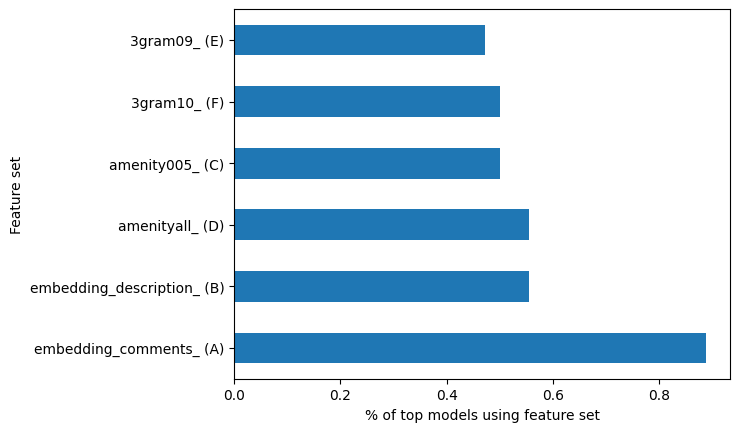

In [54]:
# split feature_set into individual feature sets
letters = ["(A)", "(B)", "(C)", "(D)", "(E)", "(F)"]
top["feature_set_split"] = top["feature_set"].apply(lambda x: x.split(", "))
for letter in ["(A)", "(B)", "(C)", "(D)", "(E)", "(F)"]:
    top[letter] = top["feature_set_split"].apply(lambda x: letter in x)

# lets see what percent of the top models have each feature set (top models will be above 80% accuracy)
with_accuracy = top[["top_model_accuracy"] + letters]
models_above_90_accuracy = with_accuracy[with_accuracy.top_model_accuracy > 0.9]
print(f"There are {models_above_90_accuracy.shape[0]} models above 90% accuracy")
feature_set_distr = models_above_90_accuracy.sum().drop("top_model_accuracy").sort_values(ascending=False) / models_above_90_accuracy.shape[0]


# convert back to feature set name
# reverse feature_set_to_letter
feature_set_to_letter = {v: k for k, v in feature_set_to_letter.items()}
feature_set_distr.index = feature_set_distr.index.map(lambda x: feature_set_to_letter[x] + " " + x)
feature_set_distr.plot(kind="barh", xlabel="% of top models using feature set", ylabel="Feature set")

Let's grab the best subset, and hyperparameter tune the best model!

In [66]:
top_feature_set = top.reset_index().iloc[0].feature_set.split(", ")
top_feature_set = [feature_set_to_letter[f] for f in top_feature_set]
top_feature_set

['embedding_comments_', 'embedding_description_', 'amenity005_']

In [56]:
top_feature_set = ["pca_comments_", "pca_description_", "amenity005_"]
columns_in_best_feature_set = [c for c in df.columns if any([c.startswith(f) for f in top_feature_set])]
columns_in_best_feature_set.append("label")

df_best_subset = df[columns_in_best_feature_set]

print("Best feature set:")
print(columns_in_best_feature_set)


Best feature set:
['pca_comments_0', 'pca_comments_1', 'pca_comments_2', 'pca_description_0', 'pca_description_1', 'pca_description_2', 'amenity005_lockbox', 'amenity005_dishwasher', 'amenity005_pool', 'amenity005_keypad', 'amenity005_tv', 'amenity005_stove', 'amenity005_bathtub', 'amenity005_balcony', 'amenity005_shampoo', 'amenity005_garden', 'amenity005_cat', 'amenity005_family', 'amenity005_breakfast', 'label']


Fitting 5 folds for each of 70 candidates, totalling 350 fits
Best parameters:
{'leaf_size': 10, 'n_neighbors': 3}
Accuracy: 0.89


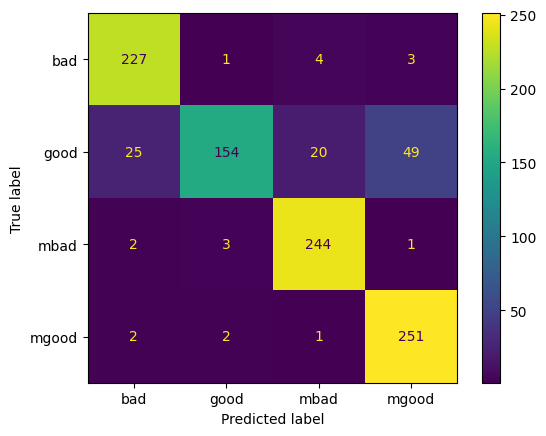

In [67]:
from sklearn.neighbors import KNeighborsClassifier

# apply GridSearchCV to find the best parameters
from sklearn.model_selection import GridSearchCV

# params for KNC
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 13, 15],
    "leaf_size": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
}

clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=-1, verbose=1)

# oversample and get train/test split
X, y = oversample.fit_resample(df_best_subset.drop(columns=["label"]), df_best_subset["label"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

# print the best parameters
print("Best parameters:")
print(clf.best_params_)

# predict
y_pred = best_clf.predict(X_test)

# evaluate
from sklearn.metrics import accuracy_score

print("Accuracy:", round(accuracy_score(y_test, y_pred), 2))

# plot a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [69]:
import plotly.express as px

best_params = clf.best_params_

# build model
etc = KNeighborsClassifier(**best_params)

# run with 1 to 10 fold cv and plot the train and test accuracy for each
from sklearn.model_selection import cross_validate

all_scores = []

for cv in range(2, 10):
    scores = cross_validate(etc, X, y, cv=cv, scoring="accuracy", return_train_score=True)
    print(f"CV = {cv}:\n\tTrain accuracy = {round(scores['train_score'].mean(), 2)}\n\tTest accuracy = {round(scores['test_score'].mean(), 2)}")
    all_scores.append({
        "folds": cv,
        "train_accuracy": scores["train_score"].mean(),
        "test_accuracy": scores["test_score"].mean()
    })


# plot the results
all_scores_df = pd.DataFrame.from_dict(all_scores)
px.line(all_scores_df, x="folds", y=["train_accuracy", "test_accuracy"], title="Train and test accuracy for different number of folds")

CV = 2:
	Train accuracy = 0.93
	Test accuracy = 0.83
CV = 3:
	Train accuracy = 0.94
	Test accuracy = 0.86
CV = 4:
	Train accuracy = 0.94
	Test accuracy = 0.87
CV = 5:
	Train accuracy = 0.94
	Test accuracy = 0.87
CV = 6:
	Train accuracy = 0.94
	Test accuracy = 0.88
CV = 7:
	Train accuracy = 0.94
	Test accuracy = 0.88
CV = 8:
	Train accuracy = 0.94
	Test accuracy = 0.88
CV = 9:
	Train accuracy = 0.94
	Test accuracy = 0.88


# Save the model along with functions to generate features

In [65]:
pickle.dump({
    "best_clf": best_clf,
    "best_feature_set": columns_in_best_feature_set,
}, open(f"../../models/best_clf_{GEO}_pca.pickle", "wb"))